# Hand-crafted finetune

I'm going to treat my hand-crafted algorithm as the weight initialisation for a training run to see what the optimisation process modifies. This will hopefully tell me what is and isn't important.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds
from physics_mi.net import print_model_params

In [2]:
# seed = np.random.randint(1, 2**32 - 1)
seed = 2813536937  # found as training mode 3 through trial and error
set_all_seeds(seed)
print(seed)

2813536937


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, dim=32, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(LinearLayer(2, dim, use_act=use_act), LinearLayer(dim, 1, use_act=False))

    def forward(self, x):
        return self.layers(x)

## Data

I'm returning to the original uniformly distributed in Y data. 

In [4]:
eps = 0.5

Y = torch.rand(10000)
X = torch.empty(10000, 2)
X[:, 0] = Y / (torch.rand(10000) * (1 - eps) + eps)
X[:, 1] = Y / X[:, 0]

# need to randomly swap x1 and x2 so that they're identically distributed - can do this because their product is commutative
mask = torch.rand(10000) < 0.5
swap_vals = X[:, 0][mask]
X[:, 0][mask] = X[:, 1][mask]
X[:, 1][mask] = swap_vals

assert torch.allclose(X[:, 0] * X[:, 1], Y)

Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

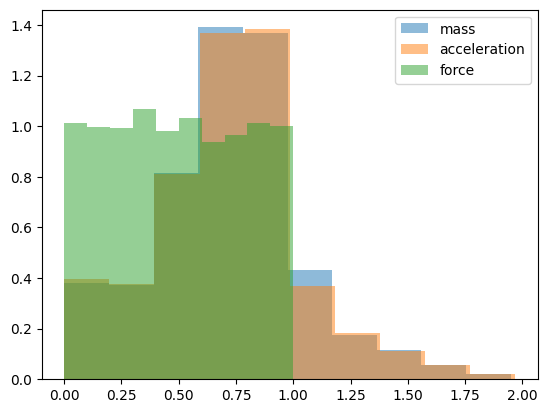

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

In [6]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Load model

In [8]:
model = Net(use_act=True, dim=2)
model.load_state_dict(torch.load("models/e-6.pth"))

<All keys matched successfully>

In [9]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=2, out_features=2, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=2, out_features=1, bias=True)
    )
  )
)

In [10]:
print_model_params(model)

layers.0.linear.weight 
 tensor([[-0.7071,  0.7071],
        [-0.7071, -0.7071]]) 

layers.0.linear.bias 
 tensor([0.0000, 1.4142]) 

layers.1.linear.weight 
 tensor([[-0.5000, -0.7071]]) 

layers.1.linear.bias 
 tensor([1.]) 



## Training

I'll just do full gradient descent to keep things simple.

In [11]:
N = 4000  # number of epochs

loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-4)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/4000 [00:00<?, ?it/s]

## Results

In [12]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model, loss_func):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

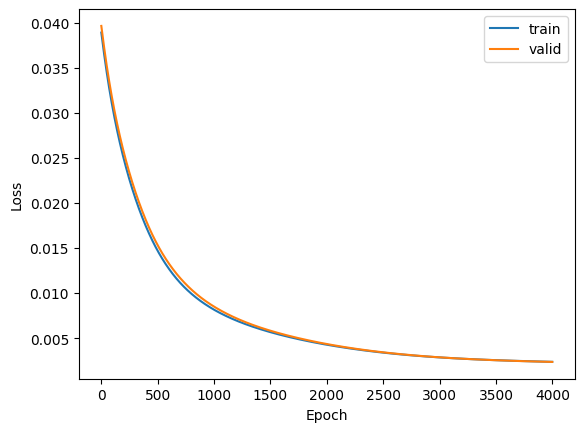

In [13]:
plot_loss(df["train_loss"], df["valid_loss"])

In [14]:
y_preds, y_targs = get_preds(model)

In [15]:
get_valid_loss(model, loss_func)

tensor(0.0024)

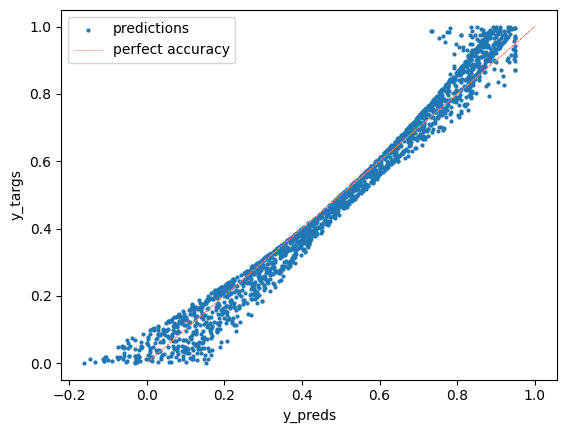

In [16]:
plot_results(y_preds, y_targs)

Looking much more like our previous plot now although the loss is still higher than in experiment 4 so we may have found a more local minimum.

## Introspection

### Inspect intermediate values

Going to go operation by operation to see if I can see what's going on.

input ($\rightarrow$ prebias_preacts $\rightarrow$ preacts $\rightarrow$ acts) ($\rightarrow$ prebias $\rightarrow$ output)

(with the layers grouped in brackets)

In [18]:
SD = model.state_dict()

In [19]:
from collections import OrderedDict


def model_breakdown(x1, x2, print_steps=True, return_steps=False):
    x1, x2 = float(x1), float(x2)

    x = torch.tensor([[x1, x2]]).T
    prebias_preacts = torch.matmul(SD["layers.0.linear.weight"], x)
    preacts = prebias_preacts[:, 0] + SD["layers.0.linear.bias"]
    acts = torch.nn.functional.relu(preacts)
    prebias = torch.matmul(SD["layers.1.linear.weight"], acts)
    output = prebias + SD["layers.1.linear.bias"]

    if print_steps:
        print("Input:", "\n", x, "\n")

        print("================ Layer 0 ================", "\n")
        print("Weight:", "\n", SD["layers.0.linear.weight"], "\n")
        print("Result:", "\n", prebias_preacts, "\n")
        print("Bias:", "\n", SD["layers.0.linear.bias"], "\n")
        print("Result:", "\n", preacts, "\n")
        print("Activations:", "\n", acts, "\n")

        print("================ Layer 1 ================", "\n")
        print("Weight:", "\n", SD["layers.1.linear.weight"], "\n")
        print("Result:", "\n", prebias, "\n")
        print("Bias:", "\n", SD["layers.1.linear.bias"], "\n")
        print("Output:", "\n", output, "\n")

        print(f"y_true = {x1*x2:.3f}")

    if return_steps:
        return prebias_preacts, preacts, acts, prebias, output


def plot_model_breakdown(
    x1,
    x2,
    ax=None,
    legend=True,
    color=None,
    product_color=False,
    point_selector={
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
):
    if not ax:
        fig = plt.figure()
        ax = plt.axes()

    input = (x1, x2)

    if not color and product_color:
        val = x1 * x2
        cmap = cm.plasma
        val = val**0.5  # looks better on the unit square with some scaling
        color = cmap(val)

    prebias_preacts, preacts, acts, prebias, output = model_breakdown(*input, print_steps=False, return_steps=True)

    x = OrderedDict()
    x["input"] = input
    x["prebias_preacts"] = prebias_preacts.flatten().tolist()
    x["preacts"] = preacts.flatten().tolist()
    x["acts"] = acts.flatten().tolist()
    x["prebias"] = [float(prebias), 0]
    x["output"] = [float(output), 0]

    markers = {}
    markers["input"] = "v"
    markers["prebias_preacts"] = "o"
    markers["preacts"] = "o"
    markers["acts"] = "o"
    markers["prebias"] = "o"
    markers["output"] = "x"

    for point_name, point in x.items():
        if point_selector[point_name]:
            ax.scatter(*point, alpha=1.0, label=point_name, color=color, marker=markers[point_name])

    x_arr = np.array(list(x.values()))

    ax.plot(*x_arr.T, lw=0.5, color=color)
    ax.set(xlabel="component 0", ylabel="component 1")
    if legend:
        ax.legend()


def get_colors(N):
    cmap = plt.get_cmap("turbo", N)
    colors = []
    for i in range(cmap.N):
        colors.append(cmap(i))
    return colors

In [20]:
model_breakdown(0.75, 1.0)

Input: 
 tensor([[0.7500],
        [1.0000]]) 

================ Layer 0 ================ 

Weight: 
 tensor([[-0.8382,  0.5413],
        [-0.6702, -0.8041]]) 

Result: 
 tensor([[-0.0874],
        [-1.3067]]) 

Bias: 
 tensor([0.0158, 1.5298]) 

Result: 
 tensor([-0.0716,  0.2231]) 

Activations: 
 tensor([0.0000, 0.2231]) 

================ Layer 1 ================ 

Weight: 
 tensor([[-0.3242, -0.9099]]) 

Result: 
 tensor([-0.2030]) 

Bias: 
 tensor([0.9479]) 

Output: 
 tensor([0.7449]) 

y_true = 0.750


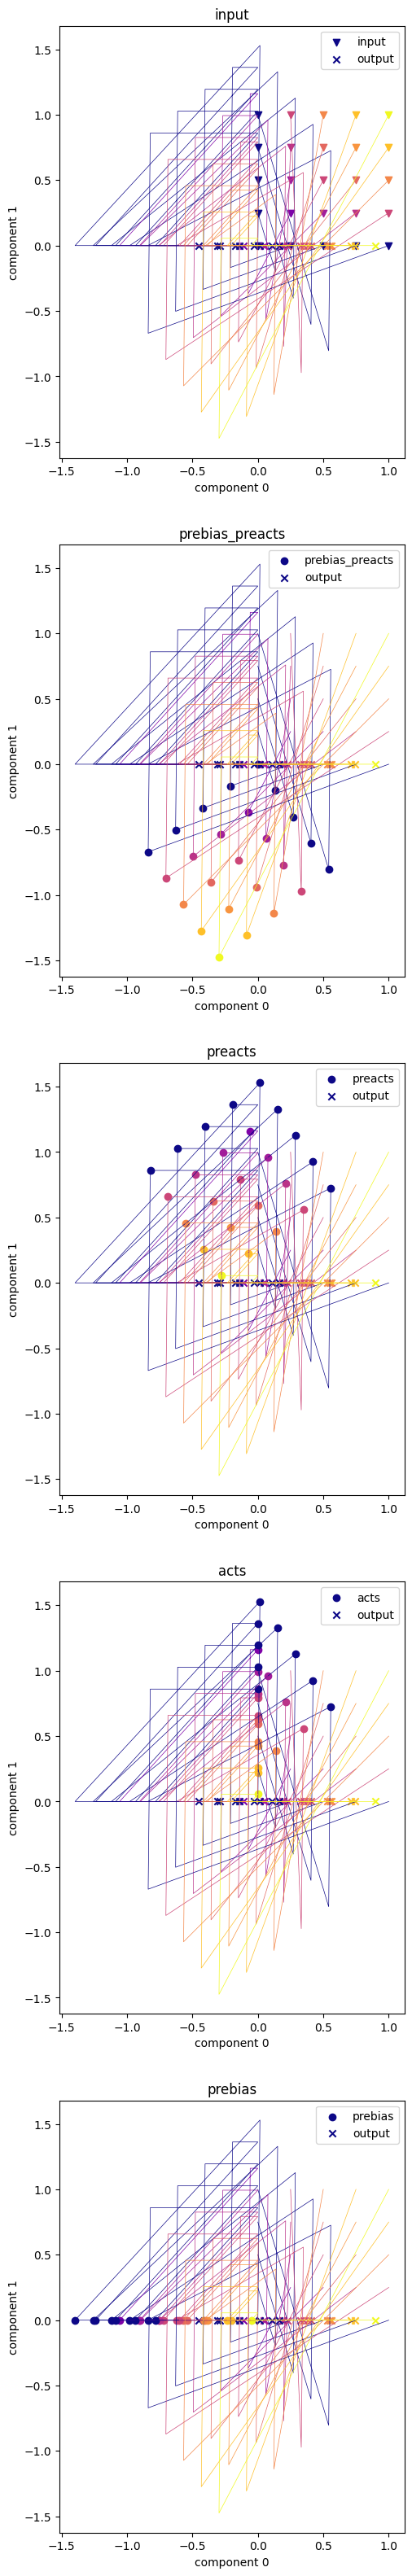

In [21]:
fig, axes = plt.subplots(5, 1, figsize=(10, 40))

N = 5
pairs = np.concatenate(np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T)

# cols = get_colors(len(pairs))

subsets = [
    {
        "input": True,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": True,
        "preacts": False,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": True,
        "acts": False,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": True,
        "prebias": False,
        "output": True,
    },
    {
        "input": False,
        "prebias_preacts": False,
        "preacts": False,
        "acts": False,
        "prebias": True,
        "output": True,
    },
]

titles = ["input", "prebias_preacts", "preacts", "acts", "prebias"]

for ax, subset, title in zip(axes.flatten(), subsets, titles):
    plot_model_breakdown(*pairs[0], ax, product_color=True, point_selector=subset)
    for pair in pairs[1:]:
        plot_model_breakdown(*pair, ax, legend=False, product_color=True, point_selector=subset)
    ax.set_title(title)
    ax.set_aspect("equal")

This is interesting to me for a number of reasons:
1. it's more proof that the skew is important. I took it out, but the optimisation put it back in.
1. it seems the resulting y-displacement at the `preacts` stage is not extremely important (as long as all points are positive in y I suppose) as it has barely changed it (only slightly perhaps to account for the skewed unit square now)
1. I think the interplay between the skew and the final linear operation (+ bias) is not one I fully understand the mechanics of yet but I can see how they need to work together to deal with the distribution of the data and the loss function. I'm not sure if I'm going to have much luck analytically describing it with the non-linearity in the way but I wonder...
1. Like I said before, the final loss is not as low as the model from exp 4 suggesting I might have led the model into a local minimum here. I'm not doing anything fancy with learning rate annealing so that would probably increase the chances of not quite finding the right spot. Previously, I've been relying on the random initialisation to take me to more optimal parts of the parameter space. I think I might do a simple experiment just to probe this behaviour a little bit.

In [22]:
# torch.save(model.state_dict(), 'models/e-7.pth')